# Лабораторная работа 2
Выполнил: студент группы 3824М1ПМкн Бугров Андрей Викторович.
## Цель работы
**Цель работы** — разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) с использованием фреймворка PyTorch.

## Задачи работы

Выполнение лабораторной работы предполагает решение следующих задач:

1. Загрузить набор данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) и выполнить предобработку данных, если это необходимо.
2. Реализовать сверточную нейронную сеть с использованием фреймворка PyTorch.
3. Выбрать подходящую функцию потерь и настроить гиперпараметры обучения.
4. Обучить реализованную нейронную сеть и провести оценку качества её работы.

In [75]:
import time
import os

import torch
import torchvision
import matplotlib.pyplot as plt


In [76]:
DIR_NAME = os.getcwd()
print(DIR_NAME)

/content


In [77]:
# About normalization coeffs: https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean, std)])

train_data = torchvision.datasets.CIFAR10(DIR_NAME, train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(DIR_NAME, train=False, download=True, transform=transform)

In [78]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2, shuffle=True) # независимость от порядка данных
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2, shuffle=False) # нет смысла

In [79]:
print(f'Размер тренировочной выборки изображений: {train_loader.dataset.data.shape}')
print(f'Размер тренировочной выборки меток: {len(train_loader.dataset.targets)}')
print(f'Размер тестовой выборки изображений: {test_loader.dataset.data.shape}')
print(f'Размер тестовой выборки меток: ({len(test_loader.dataset.targets)})')

Размер тренировочной выборки изображений: (50000, 32, 32, 3)
Размер тренировочной выборки меток: 50000
Размер тестовой выборки изображений: (10000, 32, 32, 3)
Размер тестовой выборки меток: (10000)


In [80]:
def print_image_classes(dataset):
    dataset_classes = dataset.classes
    size = len(dataset_classes)
    fig, axes = plt.subplots(size, size, figsize=(16, 16))
    fig.suptitle("Примеры изображений")
    indeces = {}
    for dataset_class in dataset_classes:
        indeces[dataset_class] = []
    indeces['all'] = 0
    index = 0
    while(indeces['all'] < size * size):
        dataset_class = dataset.classes[dataset.targets[index]]
        if len(indeces[dataset_class]) < size:
            indeces[dataset_class].append(index)
            indeces['all'] += 1
        index += 1
    for class_index, dataset_class in enumerate(dataset_classes):
        for item_index, index in enumerate(indeces[dataset_class]):
            axes[class_index, item_index].imshow(dataset.data[index], cmap=plt.cm.binary)
            axes[class_index, item_index].axis('off')
            axes[class_index, item_index].set_title(dataset.classes[dataset.targets[index]], )
    plt.tight_layout()
    plt.show()

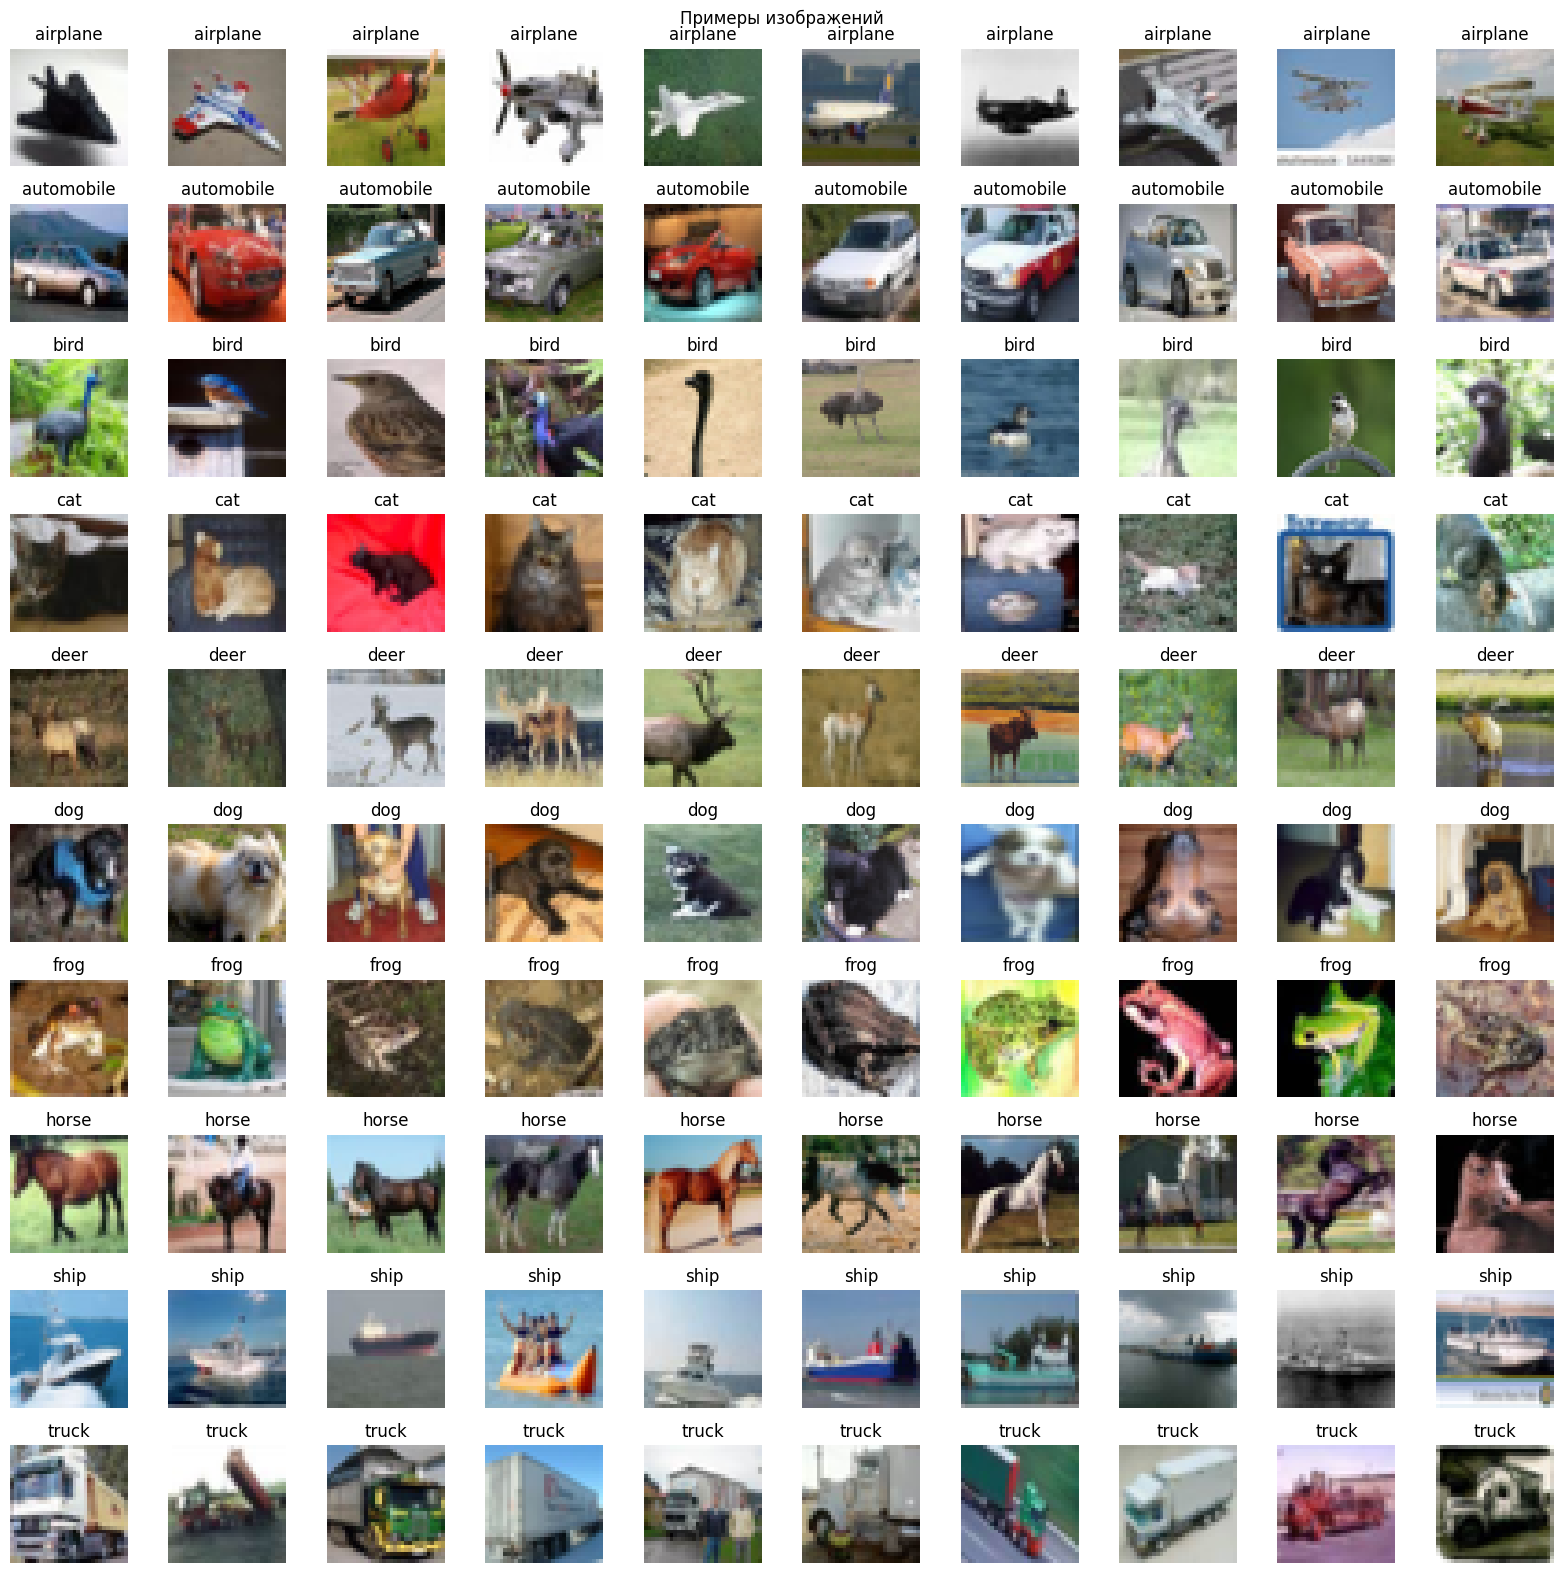

In [81]:
print_image_classes(train_data)

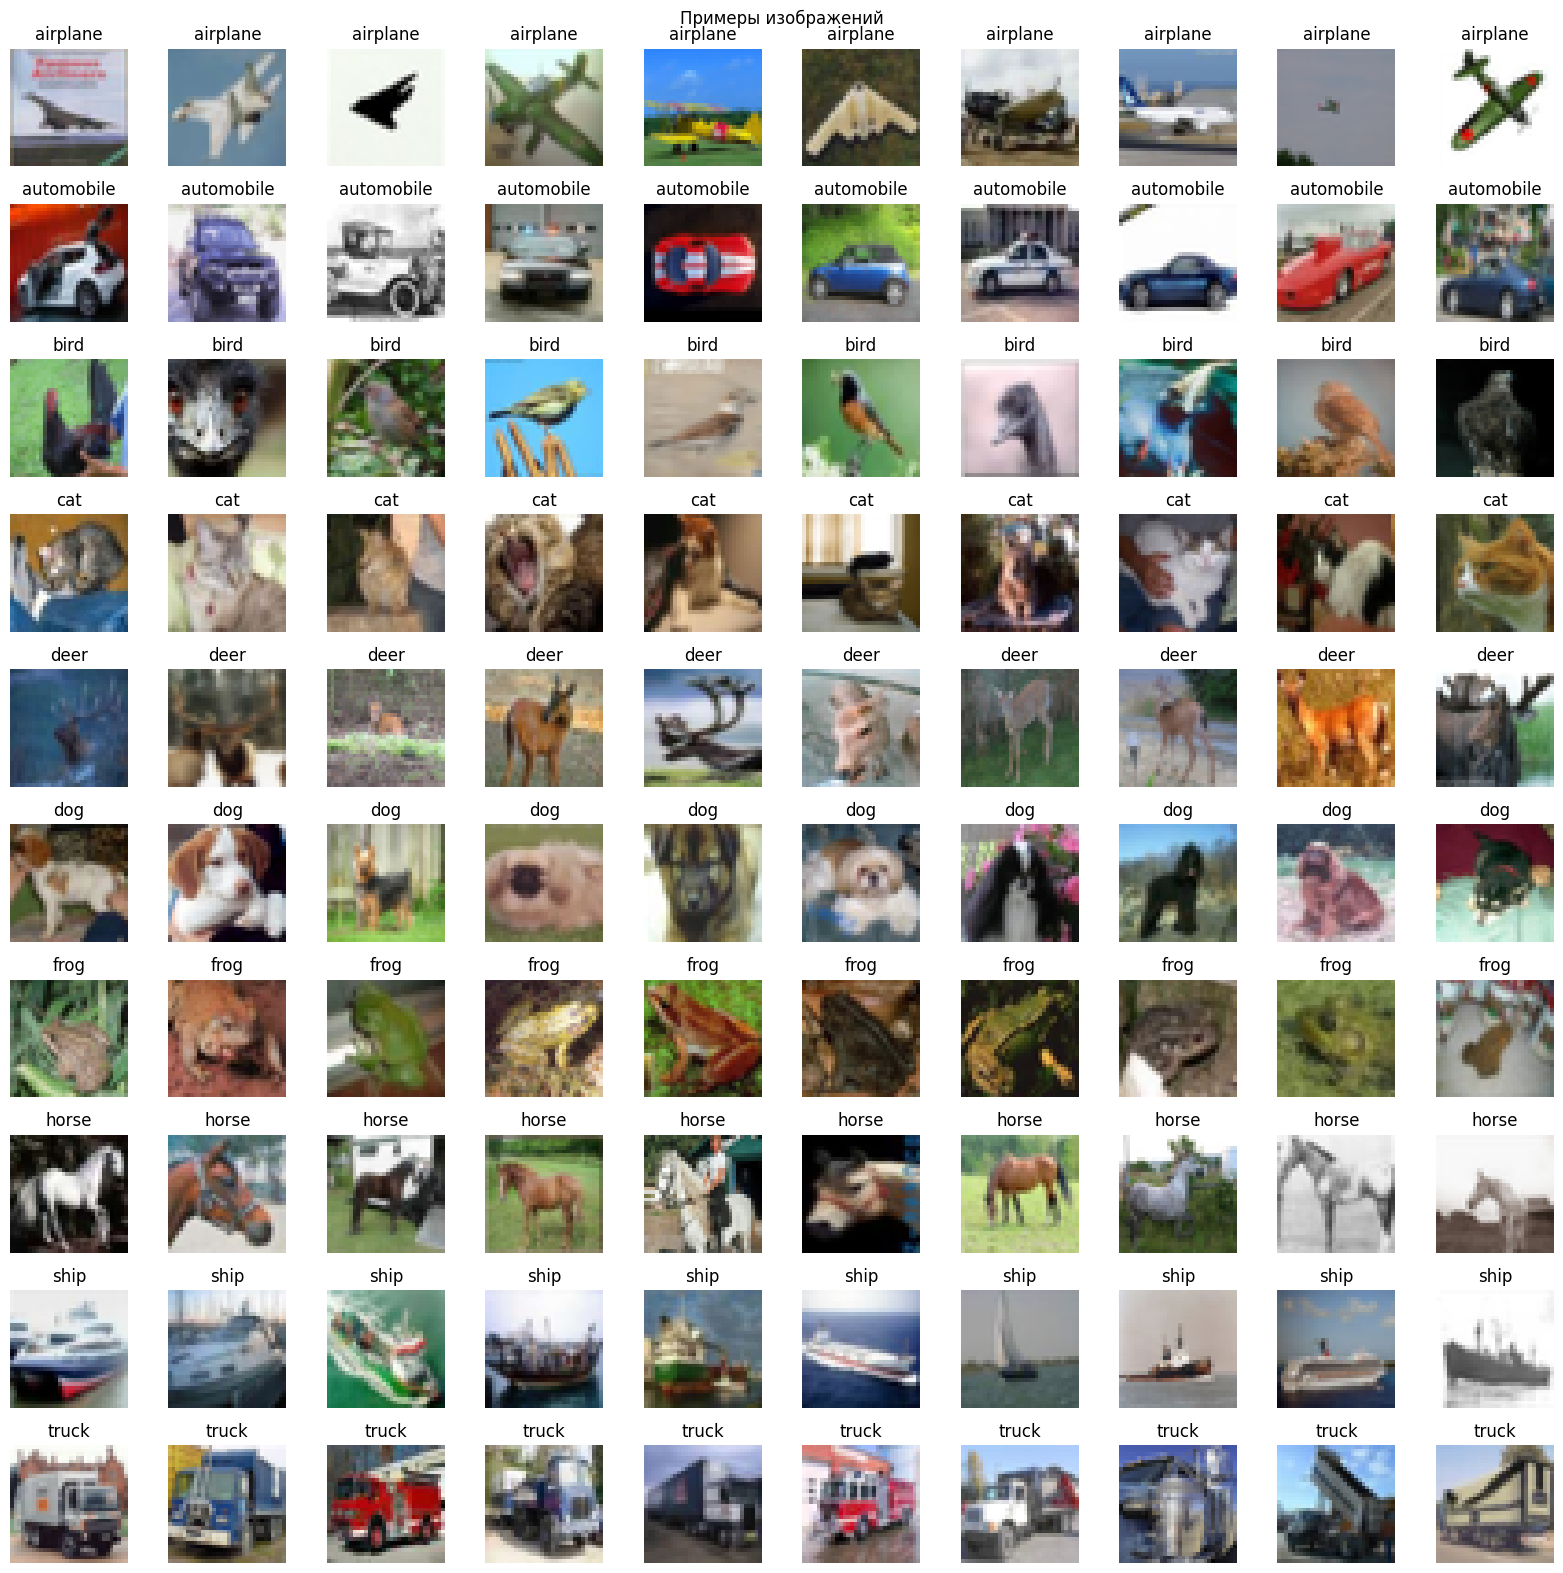

In [82]:
print_image_classes(test_data)

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [84]:
ACTIVATION_FUNCTION=torch.nn.ReLU()
LEARNING_RATE = 0.001
CONVOLUTION_KERNEL = (3, 3)
BATCH_NORMALIZATION_FUNCTION = torch.nn.BatchNorm2d

In [85]:
def convolution_layer(input_channels, output_channels, pool):
    layers = [torch.nn.Conv2d(input_channels, output_channels, kernel_size = CONVOLUTION_KERNEL, padding = 1),
              BATCH_NORMALIZATION_FUNCTION(output_channels),
              ACTIVATION_FUNCTION]

    if pool:
        layers.append(torch.nn.MaxPool2d(2)) # max pooling

    return torch.nn.Sequential(*layers) # all stages are sequential (one input, one output)

In [86]:
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self, input_channels = 3, output_channels = 10):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self._convolutions = torch.nn.Sequential(
            convolution_layer(input_channels, 64, False),
            convolution_layer(64, 64, False),
            convolution_layer(64, 128, True),
            convolution_layer(128, 128, False),
            convolution_layer(128, 256, True),
            convolution_layer(256, 256, False),
            convolution_layer(256, 512, True),
            convolution_layer(512, 512, False))



        self._adaptive_pool = torch.nn.AdaptiveAvgPool2d((1, 1)) # каждая карта признаков к 1x1 независимо от размера входа

        self._fully_connected_layer = torch.nn.Linear(512, output_channels)

    def forward(self, x):
        out = self._convolutions(x)
        out = self._adaptive_pool(out)
        out = out.view(out.size(0), -1)     # Преобразование в вектор (batch_size, 512)
        out = self._fully_connected_layer(out) # shape: [batch_size, class_count]
        return out

In [87]:
model = ConvolutionalNeuralNetwork().to(device)
loss_function = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [88]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    accuracy_list = []
    loss_list = []

    for data in train_loader:
        images = data[0].to(device)
        labels = data[1].to(device)

        # Обнуление градиентов, потому что все параметры встречаются единожды (иначе град-ты накапливаются)
        optimizer.zero_grad()

        probabilities_per_class = model(images)

        loss = criterion(probabilities_per_class, labels)
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step() # update model weights using gradients from backward

        accuracy_list.append((torch.argmax(probabilities_per_class, dim=1) == labels).float().mean()) # max by image, mean by batch

    avg_loss = torch.tensor(loss_list).mean()
    avg_accuracy = torch.tensor(accuracy_list).mean()

    return avg_loss.cpu().detach().numpy(), avg_accuracy.cpu().detach().numpy()

In [89]:
loss_list = []
acc_list = []

epochs = 20
print("Начало обучения")
train_start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()

    avg_loss, avg_accuracy = train_one_epoch(model, train_loader, loss_function, optimizer, device)

    epoch_duration = time.time() - epoch_start_time
    print(f"Эпоха: {epoch + 1}/{epochs}")
    print(f"\tВремя: {epoch_duration:.3f}")
    print(f"\tОшибка: {avg_loss:.5f}")
    print(f"\tТочность: {avg_accuracy:.5f}")

    loss_list.append(avg_loss)
    acc_list.append(avg_accuracy)

train_end_time = time.time()
total_duration = train_end_time - train_start_time
print(f"Общее время: {total_duration:.3f} сек")
print('Обучение завершено!')

Начало обучения
Эпоха: 1/20
	Время: 25.269
	Ошибка: 1.34365
	Точность: 0.50557
Эпоха: 2/20
	Время: 25.156
	Ошибка: 0.78537
	Точность: 0.72249
Эпоха: 3/20
	Время: 25.091
	Ошибка: 0.58777
	Точность: 0.79388
Эпоха: 4/20
	Время: 24.854
	Ошибка: 0.47240
	Точность: 0.83376
Эпоха: 5/20
	Время: 24.679
	Ошибка: 0.38236
	Точность: 0.86663
Эпоха: 6/20
	Время: 24.830
	Ошибка: 0.30679
	Точность: 0.89258
Эпоха: 7/20
	Время: 24.747
	Ошибка: 0.23766
	Точность: 0.91722
Эпоха: 8/20
	Время: 24.739
	Ошибка: 0.18387
	Точность: 0.93502
Эпоха: 9/20
	Время: 24.726
	Ошибка: 0.13990
	Точность: 0.95057
Эпоха: 10/20
	Время: 24.737
	Ошибка: 0.10919
	Точность: 0.96116
Эпоха: 11/20
	Время: 24.702
	Ошибка: 0.08701
	Точность: 0.96931
Эпоха: 12/20
	Время: 24.716
	Ошибка: 0.07213
	Точность: 0.97406
Эпоха: 13/20
	Время: 24.548
	Ошибка: 0.06445
	Точность: 0.97722
Эпоха: 14/20
	Время: 24.652
	Ошибка: 0.05441
	Точность: 0.98136
Эпоха: 15/20
	Время: 24.715
	Ошибка: 0.05091
	Точность: 0.98288
Эпоха: 16/20
	Время: 24.709
	Ошиб

In [90]:
def test(data_loader):
    total_loss = 0
    total_accuracy = 0
    print(len(data_loader))
    with torch.no_grad(): # do not update gradients to keep the model stable
        for raw_images_batch, raw_labels_batch in data_loader:
            images = raw_images_batch.to(device)
            labels = raw_labels_batch.to(device)

            probabilities_per_class = model(images)
            total_loss += loss_function(probabilities_per_class, labels).item() # just value
            _, predicted_classes = torch.max(probabilities_per_class.data, 1)
            total_accuracy += (predicted_classes == labels).sum().item()

    print(f"Ошибка: {total_loss / len(test_loader.dataset.targets):.4f}")
    print(f"Точность: {total_accuracy / len(test_loader.dataset.targets):.4f}")

In [91]:
test(test_loader)

157
Ошибка: 0.0106
Точность: 0.8616


Итоговая точность на тестовой выборке: около 0.86

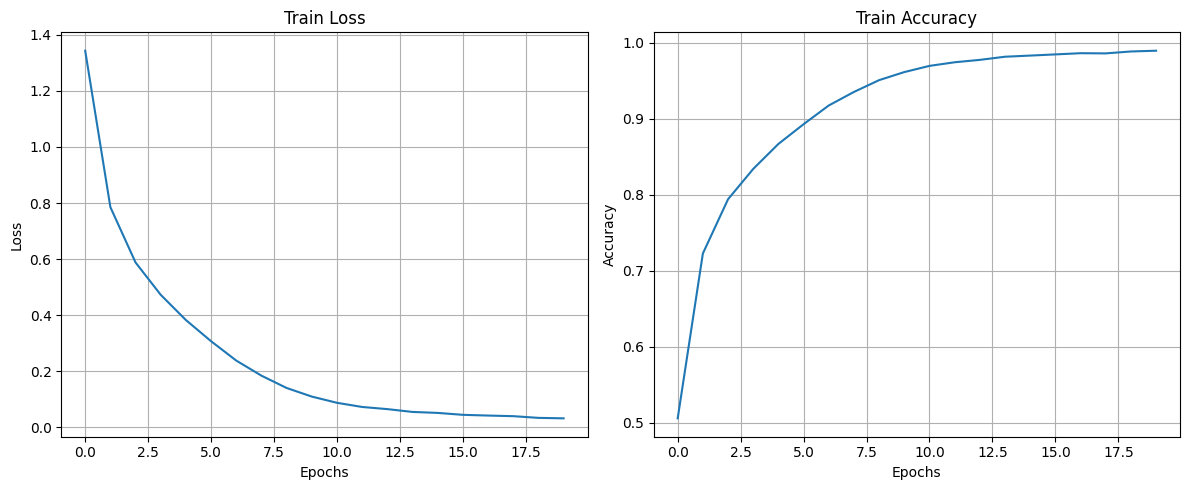

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(loss_list)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')
ax1.grid(True)

ax2.plot(acc_list)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()